# Задача 12 (бонус). Экспериментальное исследование алгоритмов решения задачи достижимости с КС ограничениями

## Введение

В данной работе рассматривается задача достижимости в графе с контекстно-свободными ограничениями: исследуется производительность нескольких алгоритмов её решения, основанных на линейной алгебре, а также проводится их сравнение с решением схожей задачи при регулярных ограничениях. Алгоритмы реализованы на языке Python так, что матричные операции осуществляются на CUDA-ядрах GPU при помощи библиотеки [pyCuBool](https://pypi.org/project/pycubool/).


### Описание задачи достижимости
Пусть имеется размеченный граф $G(V, E, Lab)$. Тогда конечный автомат построенный по этому графу (рёбра → переходы, вершины → состояния) допускает регулярный язык $L_G$

Пусть нам задана КС-грамматика $CFG$, задающая язык ограничений $L_{CFG}$.

Тогда задача достижимости заключается в нахождение следующего множества: $CFPQ = \{(v_i, v_j)|\exists\pi:w(v_i\pi v_j)\in L, v_i\in V_S, v_j\in V_F\}$, где $L = L_G\cap L_{CFG}$, $V_S \in V$ --- множество стартовых вершин и $V_F \in V$ --- множество финальных вершин

### Исследуемые решения

Рассматриваются следующие алгоритмы решения задачи достижимости с контекстно-свободными ограничениями. В каждом алгоритме строится транзитивное замыкание графа с учётом правил ограничивающей грамматики:

1. Алгоритм Хеллингса. Грамматика переводится в ОНФХ. Поддерживается множество рёбер графа, которые ещё не были рассмотрены. Рассмотрение очередного ребра заключается в проверке его в паре с каждым смежным с ним ребром на порождаемость в грамматике. В случае, если пара порождаема, то на рассмотрение добавляется соответствующее ребро с порождающим символом. 

2. Матричный алгоритм. Грамматика переводится в ОНФХ. Затем строится матрица смежности графа, по которой вычисляется транзитивное замыкание --- пока матрица меняется проводится аккумулирование результата возведения её в квадрат.

3. Тензорный алгоритм. По грамматике строится рекурсивный автомат. Для графа и полученного автомата строятся матрицы смежности. Затем, пока транзитивное замыкание не построено (пока в нём добавляются новые рёбра), строится пересечение матриц и его транзитивное замыкание, новые рёбра которого добавляются в графи его матрицу смежности.

Также для сравнения с вышеприведёнными алгоритмами используется алгоритм решения задачи $RPQ$ между всеми парами вершин, так как в [предыдущей работе](https://colab.research.google.com/drive/1Gau-VhZ0J6JO7-60HCzNHnrSo1N51MS_?usp=sharing) согласно экспериментам было получено, что лучше других подходит данной постановке задачи. 
Дополнительно стоит отметить, что алгоритм Хеллингса не использует матричные операции и его реализация не использует технологию $GPGPU$

### Цель работы

Целью данной работы является сравнение решений задачи достижимости с ограничениями в терминах формальных языков, а именно, нахождение ответов на следующие вопросы:

1. Какой из трёх указанных алгоритмов решения задачи с контекстно-свободными ограничениями (Хеллингса, матричный или тензорный) обладает лучшей производительностью?
2. Имеет ли смысл для решения задачи достижимости с регулярными ограничениями использовать алгоритмы для контекстно-свободных ограничений (ведь регулярные --- частный случай КС) или всё же лучше использовать специализированные алгоритмы для регулярных ограничений?


## Описание экспериментов

### Подготовка окружения

In [1]:
# Установка проекта https://github.com/Krekep/formal-lang-course
!git clone -b task12 https://github.com/Krekep/formal-lang-course.git

Cloning into 'formal-lang-course'...
remote: Enumerating objects: 689, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 689 (delta 64), reused 82 (delta 53), pack-reused 589
Receiving objects: 100% (689/689), 2.63 MiB | 6.79 MiB/s, done.
Resolving deltas: 100% (365/365), done.


In [2]:
%%capture
# Установка зависимостей проекта
!pip install -r formal-lang-course/requirements.txt
# Установка библиотеки pycubool
!pip install pycubool

# Установка библиотек для красивых графиков
!pip install matplotlib
!pip install seaborn

In [3]:
# Подключение директории проекта
import sys
sys.path.insert(1, "formal-lang-course")

### Характеристики оборудования

In [4]:
# Сведения об операционной системе
!cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.6 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.6 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [5]:
# Сведения об используемом CPU
!lscpu | grep 'Model name'
!lscpu | grep 'Socket(s)'
!lscpu | grep 'Core(s) per socket:'
!lscpu | grep 'Thread(s) per core'
!lscpu | grep "MHz"

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Socket(s):           1
Core(s) per socket:  1
Thread(s) per core:  2
CPU MHz:             2200.154


In [6]:
# Сведения об используемом GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [7]:
# Сведения о размере оперативной памяти системы в GB
!echo 'Total RAM (GB)'
!awk '( $1 == "MemTotal:" ) { print $2/1048576 }' /proc/meminfo

Total RAM (GB)
12.6812


### Описание данных для экспериментов

В качестве графов для экспериментов будем использовать графы из [cfpq-data](https://jetbrains-research.github.io/CFPQ_Data/dataset/index.html) датасета. Были выбраны следующие графы из различных категорий:

* RDF-графы: [skos](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/go.html#go), [atom](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/atom.html#atom), [go_hierarchy](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/go_hierarchy.html#go-hierarchy), [go](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/go.html#go)
* Графы языка Си: [bzip](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/go.html#go), [ls](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/ls.html#ls), [apache](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/apache.html#apache)
* Графы языка Java: [lusearch](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/lusearch.html#lusearch), [sunflow](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/sunflow.html#sunflow), [pmd](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/pmd.html#pmd), [jython](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/jython.html#jython)

Использовать для замеров графы, обладающие большим числом вершин, на представленном оборудовании оказалось невозможно из-за нехватки видеопамяти для алгоритмов, использующих GPU. Выбранные графы были взяты разных размеров, от маленьких на несколько сотен вершин, до графов с несколькими миллионами вершин, в том числе с несколькими компонентами связности.

In [8]:
GRAPH_NAMES = [
    # Маленькие графы
    "skos",
    "bzip",
    "ls",
    "atom",
    
    # Большие графы
    "sunflow",
    "lusearch",
    "go_hierarchy",
    "go",
    "apache",
    "pmd",
    "jython"
]
SMALL_GRAPHS = {
    # Маленькие графы
    "skos",
    "bzip",
    "ls",
    "atom"
}
LARGE_GRAPHS = {
    # Большие графы
    "sunflow",
    "lusearch",
    "go_hierarchy",
    "go",
    "apache",
    "pmd",
    "jython"
}
GRAPHS_RDF = ["skos", "atom", "go_hierarchy", "go"]
GRAPHS_C = ["bzip", "ls", "apache"]
GRAPHS_JAVA = ["lusearch", "sunflow", "pmd", "jython"]

In [9]:
## Для получения информации о графах необходимо раскомментировать эту ячейку и запустить

# Информация о графах

# from project.graph_utils import get_graph_info
# from project.manager import get_graph
# import pandas as pd 
# import cfpq_data

# edges = []
# nodes = []

# for graph_name in GRAPH_NAMES:
#     graph_info = get_graph_info(get_graph(graph_name))
#     edges.append(graph_info.edges)
#     nodes.append(graph_info.nodes)


# df = pd.DataFrame(
#     {
#         "Edges": edges,
#         "Nodes": nodes,
#     },
#     index=GRAPH_NAMES
# )
# df

### Запросы

Для каждой группы графов были выбраны свои контекстно-свободные запросы:

* Для RDF-графов: 
    1. `S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type`
    2. `S -> subClassOf_r S subClassOf | subClassOf_r subClassOf`
    3. `S -> type_r S type | type_r type` 
* Для графов языка C:
```
S -> d_r V d
V -> V1 V2 V3
V1 -> epsilon
V1 -> V2 a_r V1
V2 -> epsilon
V2 -> S
V3 -> epsilon
V3 -> a V2 V3
```
* Для графов языка Java:
```
S -> PTh alloc
PTh -> epsilon
PTh -> assign PTh
(for each field f) PTh -> load_f Al store_f PTh
FT -> alloc_r FTh
FTh -> epsilon
FTh -> assign_r FTh
(for each field f) FTh -> store_f_r Al load_f_r FTh
Al -> S FT
```

Регулярные запросы были взяты из [предыдущей работы](https://colab.research.google.com/drive/1Gau-VhZ0J6JO7-60HCzNHnrSo1N51MS_?usp=sharing) (если в графе число меток меньше числа запросов, тогда метки дополняются уже имеющимися. В графе должна быть по крайней мере 1 метка, иначе эксперимент не имеет смысла):
- $(L_0 | L_1 | L_2)^* \: L_3$
- $(L_0 | L_2)$+ ${L_1}^*$
- $L_0\,L_1\,L_2\,(L_3 | L_1)^*$
- $(L_0 | L_3)^*\,\,|\,\,(L_1 | L_2)^*$
- $(L_0 L_1 L_2)^* | L_3$

Для алгоритмов решения задачи $CFPQ$ регулярные запросы переводились в КС грамматики.

In [10]:
# Генерация регулярных выражений

from pyformlang.regular_expression.regex_objects import Symbol
from pyformlang.regular_expression import Regex

NUMBER_OF_LABELS = 4

def regex_from_label(label):
    regex = Regex("")
    regex.head = Symbol(str(label))
    return regex

def expand(lst, expand_size):
    """
    If number of labels < NUMBER_OF_LABELS, then expand them with existing ones
    """
    expand_length = expand_size - len(lst)
    if expand_length <= 0:
        return lst
    expanded_lst = lst.copy()
    for i in range(expand_length):
        expanded_lst.append(expanded_lst[i])
    return expanded_lst

def regex_first(labels):
    """
    (l0 | l1 | l2)* l3
    """
    labels = expand(labels, NUMBER_OF_LABELS)
    regex_0 = regex_from_label(labels[0])
    regex_1 = regex_from_label(labels[1])
    regex_2 = regex_from_label(labels[2])
    regex_3 = regex_from_label(labels[3])
    return regex_0.union(regex_1).union(regex_2).kleene_star().concatenate(regex_3)
  

def regex_second(labels):
    """
    (l0 | l2)+ l1*
    """
    labels = expand(labels, NUMBER_OF_LABELS)
    regex_0 = regex_from_label(labels[0])
    regex_1 = regex_from_label(labels[1])
    regex_2 = regex_from_label(labels[2])
    return regex_0.union(regex_2).union(regex_1.kleene_star())

def regex_third(labels):
    """
    l0 l1 l2 (l3 | l1)*
    """ 
    labels = expand(labels, NUMBER_OF_LABELS)
    regex_0 = regex_from_label(labels[0])
    regex_1 = regex_from_label(labels[1])
    regex_2 = regex_from_label(labels[2])
    regex_3 = regex_from_label(labels[3])
    return regex_0.concatenate(regex_1).concatenate(regex_2).concatenate((regex_3.union(regex_1)).kleene_star())

def regex_fourth(labels):
    """
    (l0 | l3)* | (l1 | l2)*
    """
    labels = expand(labels, NUMBER_OF_LABELS)
    regex_0 = regex_from_label(labels[0])
    regex_1 = regex_from_label(labels[1])
    regex_2 = regex_from_label(labels[2])
    regex_3 = regex_from_label(labels[3])
    left_regex = (regex_0.union(regex_3)).kleene_star()
    right_regex = (regex_1.union(regex_2)).kleene_star()
    return left_regex.union(right_regex)

def regex_fifth(labels):
    """
    (l0 l1 l2)* | l3
    """
    labels = expand(labels, NUMBER_OF_LABELS)
    regex_0 = regex_from_label(labels[0])
    regex_1 = regex_from_label(labels[1])
    regex_2 = regex_from_label(labels[2])
    regex_3 = regex_from_label(labels[3])
    return regex_0.concatenate(regex_1).concatenate(regex_2).kleene_star().union(regex_3)

def reg_to_cfg(r):
    return lambda labs: r(labs).to_cfg()

CFG_GENERATORS = ((regex_first.__doc__.strip().strip('\n'), reg_to_cfg(regex_first)), 
                  (regex_second.__doc__.strip().strip('\n'), reg_to_cfg(regex_second)), 
                  (regex_third.__doc__.strip().strip('\n'), reg_to_cfg(regex_third)), 
                  (regex_fourth.__doc__.strip().strip('\n'), reg_to_cfg(regex_fourth)), 
                  (regex_fifth.__doc__.strip().strip('\n'), reg_to_cfg(regex_fifth))
                 )

REG_GENERATORS = ((regex_first.__doc__.strip().strip('\n'), regex_first), 
                  (regex_second.__doc__.strip().strip('\n'), regex_second), 
                  (regex_third.__doc__.strip().strip('\n'), regex_third), 
                  (regex_fourth.__doc__.strip().strip('\n'), regex_fourth), 
                  (regex_fifth.__doc__.strip().strip('\n'), regex_fifth)
                 )

In [11]:
import pyformlang.cfg as c
import cfpq_data


def get_cf_queries(graph):
    if graph in GRAPHS_RDF:
        return list(CFG_RDF.items())
    elif graph in GRAPHS_C:
        return list(CFGS_C.items())
    elif graph in GRAPHS_JAVA:
        return list(CFGS_JAVA.items())
    else:
        raise ValueError("Unknown graph")


CFG_RDF = {
    "rdf_1": c.CFG.from_text(
        "S -> subClassOf_r S subClassOf | subClassOf_r subClassOf | type_r S type | type_r type"
    ),
    "rdf_2": c.CFG.from_text("S -> subClassOf_r S subClassOf | subClassOf_r subClassOf"),
    "rdf_3": c.CFG.from_text("S -> type_r S type | type_r type"),
}

CFGS_C = {
    "c_alias": c.CFG.from_text(
        """
        S -> d_r V d
        V -> V1 V2 V3
        V1 -> epsilon
        V1 -> V2 a_r V1
        V2 -> epsilon
        V2 -> S
        V3 -> epsilon
        V3 -> a V2 V3
        """
    )
}

CFGS_JAVA = {
    "java_points_to": c.CFG.from_text(
        """
        S -> PTh alloc
        PTh -> epsilon
        PTh -> assign PTh
        PTh -> load_0 Al store_0 PTh
        PTh -> load_1 Al store_1 PTh
        FT -> alloc_r FTh
        FTh -> epsilon
        FTh -> assign_r FTh
        FTh -> store_0_r Al load_0_r FTh
        FTh -> store_1_r Al load_1_r FTh
        Al -> S FT
        """
    )
}

### Определение нужных замеров

Для ответа на первый вопрос (о сравнении производительности КС-алгоритмов) необходимо замерить время работы каждого КС-алгоритма на каждом графе и КС-запросе.  Алгоритм, затрачивающий наименьшее число времени для решения задачи, будет обладать наибольшей производительностью.

Для ответа на второй вопрос (о выгоде от использования специальных алгоритмов для регулярных запросов) необходимо замерить время работы каждого КС-алгоритма и наиболее быстрого из алгоритмов для регулярных запросов (выбранного по результату предыдущей работы) на каждом графе и каждом регулярном запросе. В случае, если регулярный алгоритм окажется быстрее всех КС-алгоритмов, использовать его для регулярных запросов будет эффективнее.

Итого, для каждого графа и каждого КС-запроса нужно провести замеры времени работы КС-алгоритмов, а также для каждого графа и каждого регулярного запроса нужно провести замеры времени работы КС-алгоритмов и выбранного регулярного алгоритма.


Время работы каждого алгоритма для маленьких графов замерялось пять раз подряд для дальнейшего усреднения. Для больших графов время выполнение функции замеряется единожды для каждого запроса. Данное решение обосновано незначительностью погрешности времени выполнения на больших графах и вычислительными возможностями оборудования.

### Алгоритмы CFPQ

#### Реализация через scipy

In [12]:
from project.cfpq import cfpq_by_hellings

import sources directory


#### Реализация через pycubool

In [13]:
"""
Декомпозиция автомата в качестве булевых матриц
"""

import pycubool as cb

from pyformlang.finite_automaton import (
    State,
    NondeterministicFiniteAutomaton,
    FiniteAutomaton,
)


class CuBoolAutomaton:
    """
    Class representing boolean matrix decomposition of finite automaton
    """

    def __init__(self):
        self.num_states = 0
        self.start_states = set()
        self.final_states = set()
        self.bool_matrices = {}
        self.state_indices = {}

    @classmethod
    def from_automaton(cls, automaton: FiniteAutomaton):
        """
        Transform automaton to set of labeled boolean matrix
        Parameters
        ----------
        automaton
            Automaton for transforming

        Returns
        -------
        CuBoolAutomaton
            Result of transforming
        """

        automaton_matrix = cls()
        automaton_matrix.num_states = len(automaton.states)
        automaton_matrix.start_states = automaton.start_states
        automaton_matrix.final_states = automaton.final_states
        automaton_matrix.state_indices = {
            state: idx for idx, state in enumerate(automaton.states)
        }
        for s_from, trans in automaton.to_dict().items():
            for label, states_to in trans.items():
                if not isinstance(states_to, set):
                    states_to = {states_to}
                for s_to in states_to:
                    idx_from = automaton_matrix.state_indices[s_from]
                    idx_to = automaton_matrix.state_indices[s_to]
                    if label not in automaton_matrix.bool_matrices.keys():
                        automaton_matrix.bool_matrices[label] = cb.Matrix.empty(shape=(automaton_matrix.num_states, automaton_matrix.num_states))
                    automaton_matrix.bool_matrices[label][idx_from, idx_to] = True

        return automaton_matrix

    @classmethod
    def from_rsm(cls, rsm):
        """
        Transform automaton to set of labeled boolean matrix
        Parameters
        ----------
        rsm
            Automaton for transforming
        Returns
        -------
        AutomatonSetOfMatrix
            Result of transforming
        """

        states, start_states, final_states = set(), set(), set()
        for var, nfa in rsm.boxes.items():
            for s in nfa.states:
                state = State((var, s.value))
                states.add(state)
                if s in nfa.start_states:
                    start_states.add(state)
                if s in nfa.final_states:
                    final_states.add(state)

        states = sorted(states, key=lambda v: (v.value[0].value, v.value[1]))
        state_to_idx = {s: i for i, s in enumerate(states)}

        automaton_matrix = cls()
        automaton_matrix.num_states = len(states)
        automaton_matrix.start_states = start_states
        automaton_matrix.final_states = final_states
        automaton_matrix.state_indices = state_to_idx


        for var, nfa in rsm.boxes.items():
            for state_from, transitions in nfa.to_dict().items():
                for label, states_to in transitions.items():
                    if label not in automaton_matrix.bool_matrices.keys():
                        automaton_matrix.bool_matrices[label] = cb.Matrix.empty(shape=(automaton_matrix.num_states, automaton_matrix.num_states))
                    states_to = states_to if isinstance(states_to, set) else {states_to}
                    for state_to in states_to:
                        automaton_matrix.bool_matrices[label][
                            state_to_idx[State((var, state_from.value))],
                            state_to_idx[State((var, state_to.value))],
                        ] = True

        return automaton_matrix

    def to_automaton(self) -> NondeterministicFiniteAutomaton:
        """
        Transform set of labeled boolean matrix to automaton.

        Parameters
        ----------
        self
            Set of boolean matrix with label as key

        Returns
        -------
        CuBoolAutomaton
            Resulting automaton
        """

        automaton = NondeterministicFiniteAutomaton()
        for label in self.bool_matrices.keys():
            for s_from, s_to in self.bool_matrices[label]:
                automaton.add_transition(s_from, label, s_to)

        for state in self.start_states:
            automaton.add_start_state(State(state))

        for state in self.final_states:
            automaton.add_final_state(State(state))

        return automaton

    @property
    def get_states(self):
        return self.state_indices.keys()

    @property
    def get_start_states(self):
        return self.start_states.copy()

    @property
    def get_final_states(self):
        return self.final_states.copy()

    def get_transitive_closure(self):
        """
        Get transitive closure of sparse.csr_matrix

        Parameters
        ----------
        self
            Class exemplar

        Returns
        -------
            Transitive closure
        """

        shape = list(self.bool_matrices.values())[0].shape
        tc = cb.Matrix.empty(shape=shape)

        if len(self.bool_matrices) != 0:
            for elem in self.bool_matrices.values():
                tc = tc.ewiseadd(elem)
            prev_nnz = tc.nvals
            new_nnz = 0

            while prev_nnz != new_nnz:
                tc.mxm(tc, out=tc, accumulate=True)  # t += t * t
                prev_nnz, new_nnz = new_nnz, tc.nvals

        return tc

    def intersect(self, other):
        """
        Get intersection of two automatons
        Parameters
        ----------
        self
            First automaton
        other
            Second automaton

        Returns
        -------
        CuBoolAutomaton
            Result of intersection
        """
        intersection = CuBoolAutomaton()
        intersection.num_states = self.num_states * other.num_states
        common_labels = set(self.bool_matrices.keys()).union(other.bool_matrices.keys())

        for label in common_labels:
            if label not in self.bool_matrices.keys():
                self.bool_matrices[label] = cb.Matrix.empty(shape=(self.num_states, self.num_states))
            if label not in other.bool_matrices.keys():
                other.bool_matrices[label] = cb.Matrix.empty(shape=(other.num_states, other.num_states))

        for label in common_labels:
            intersection.bool_matrices[label] = self.bool_matrices[label].kronecker(other.bool_matrices[label])

        for state_lhs, s_lhs_index in self.state_indices.items():
            for state_rhs, s_rhs_index in other.state_indices.items():
                new_state = new_state_idx = (
                    s_lhs_index * other.num_states + s_rhs_index
                )
                intersection.state_indices[new_state] = new_state_idx

                if state_lhs in self.start_states and state_rhs in other.start_states:
                    intersection.start_states.add(new_state)

                if state_lhs in self.final_states and state_rhs in other.final_states:
                    intersection.final_states.add(new_state)

        return intersection

In [43]:
"""
Ячейка с алгоритмом решения RPQ
"""

from networkx import MultiDiGraph
from pyformlang.regular_expression import Regex
from project.fa_utils import regex_to_dfa, nfa_to_minimal_dfa
from project.graph_utils import graph_to_nfa

def rpqCB(
    regex: Regex, graph: MultiDiGraph, start_nodes: set = None, final_nodes: set = None
):
    graph_automaton_matrix = CuBoolAutomaton.from_automaton(
        graph_to_nfa(graph, start_nodes, final_nodes)
    )
    regex_automaton_matrix = CuBoolAutomaton.from_automaton(
        nfa_to_minimal_dfa(regex.to_epsilon_nfa())
    )

    intersection = graph_automaton_matrix.intersect(regex_automaton_matrix)
    tc = intersection.get_transitive_closure()

    result = set()
    for state_from, state_to in tc:
        if (
            state_from in intersection.start_states
            and state_to in intersection.final_states
        ):
            result.add(
                (
                    state_from // regex_automaton_matrix.num_states,
                    state_to // regex_automaton_matrix.num_states,
                )
            )

    return result

In [44]:
from project.automaton_matrix import AutomatonSetOfMatrix
from project.cfg_utils import cfg_to_wcnf
from project.ecfg import ECFG
from project.graph_utils import graph_to_nfa
from pyformlang.cfg import CFG, Variable, Terminal
from project.rsm import RSM

def cb_matrix_based(graph, cfg, **kwargs):
    cfg = cfg_to_wcnf(cfg)

    # split productions in 3 groups
    eps_prods = set()  # A -> epsilon
    term_prods = {}  # A -> a
    var_prods = {}  # A -> B C
    for p in cfg.productions:
        if not p.body:
            eps_prods.add(p.head)
        elif len(p.body) == 1:
            t = p.body[0]
            term_prods.setdefault(p.head, set()).add(t)
        elif len(p.body) == 2:
            v1, v2 = p.body
            var_prods.setdefault(p.head, set()).add((v1, v2))

    # prepare adjacency matrix
    nodes_num = graph.number_of_nodes()
    nodes = {vertex: i for i, vertex in enumerate(graph.nodes)}
    nodes_reversed = {i: vertex for i, vertex in enumerate(graph.nodes)}
    matrices = {
        v: cb.Matrix.empty(shape=(nodes_num, nodes_num)) for v in cfg.variables
    }
 
    # A -> terminal
    for v, u, data in graph.edges(data=True):
        label = data["label"]
        i = nodes[v]
        j = nodes[u]
        for var in term_prods:
            if Terminal(label) in term_prods[var]:
                matrices[var][i, j] = True

    # A -> espilon loops
    for var in eps_prods:
        for i in range(nodes_num):
            matrices[var][i, i] = True

    # A -> B C
    changed = True
    while changed:
        changed = False
        for head in var_prods:
            for body_b, body_c in var_prods[head]:
                old_nnz = matrices[head].nvals
                matrices[body_b].mxm(matrices[body_c], out=matrices[head], accumulate=True)
                new_nnz = matrices[head].nvals
                changed = old_nnz != new_nnz

    return {
        (nodes_reversed[v], var, nodes_reversed[u])
        for var, matrix in matrices.items()
        for v, u in matrix.to_list()
    }

def cb_tensor_based(graph, cfg, **kwargs):
    g_matrix = CuBoolAutomaton.from_automaton(graph_to_nfa(graph))
    rsm = RSM.from_ecfg((ECFG.from_cfg(cfg)))
    rsm_matrix = CuBoolAutomaton.from_rsm(rsm)
    rsm_idx_to_state = {i: s for s, i in rsm_matrix.state_indices.items()}

    for var in cfg.get_nullable_symbols():
        if var not in g_matrix.bool_matrices.keys():
            g_matrix.bool_matrices[var] = cb.Matrix.empty(shape=(g_matrix.num_states, g_matrix.num_states))
        for i in range(g_matrix.num_states):
            g_matrix.bool_matrices[var][i, i] = True

    intersection = rsm_matrix.intersect(g_matrix)
    tc = intersection.get_transitive_closure()

    prev_nnz = tc.nvals
    new_nnz = 0

    while prev_nnz != new_nnz:
        for i, j in tc.to_list():
            rsm_i = i // g_matrix.num_states
            rsm_j = j // g_matrix.num_states

            graph_i = i % g_matrix.num_states
            graph_j = j % g_matrix.num_states

            s, f = rsm_idx_to_state[rsm_i], rsm_idx_to_state[rsm_j]
            var, _ = s.value

            if s in rsm_matrix.start_states and f in rsm_matrix.final_states:
                if var not in g_matrix.bool_matrices.keys():
                    g_matrix.bool_matrices[var] = cb.Matrix.empty(shape=(g_matrix.num_states, g_matrix.num_states))
                g_matrix.bool_matrices[var][graph_i, graph_j] = True

        tc = rsm_matrix.intersect(g_matrix).get_transitive_closure()

        prev_nnz, new_nnz = new_nnz, tc.nvals

    return {
        (u, label, v)
        for label, bm in g_matrix.bool_matrices.items()
        for u, v in bm.to_list()
    }

In [45]:
from pyformlang.cfg import Variable

from project.cfpq import cfpq

def cb_cfpq_by_matrix(
    cfg: CFG,
    graph: MultiDiGraph,
    start_symbol: Variable = Variable("S"),
    start_nodes= None,
    final_nodes= None,
    **kwargs,
):
    return cfpq(
        cfg, graph, start_symbol, start_nodes, final_nodes, cb_matrix_based, **kwargs
    )


def cb_cfpq_by_tensor(
    cfg: CFG,
    graph: MultiDiGraph,
    start_symbol: Variable = Variable("S"),
    start_nodes= None,
    final_nodes= None,
    **kwargs,
):
    return cfpq(
        cfg, graph, start_symbol, start_nodes, final_nodes, cb_tensor_based, **kwargs
    )


#### Маленький пример, чтобы рповерить что написано верно

In [46]:
import networkx as nx
import pytest
from pyformlang.cfg import CFG

from project.cfpq import cfpq_by_hellings


def _create_graph(nodes, edges) -> nx.MultiDiGraph:
    graph = nx.MultiDiGraph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(
        list(map(lambda edge: (edge[0], edge[2], {"label": edge[1]}), edges))
    )
    return graph


first = cb_cfpq_by_matrix(
    cfg=CFG.from_text(
        """
            S -> A B
            A -> a
            B -> b
        """
    ),
    graph=_create_graph(nodes=[0, 1, 2], edges=[(0, "a", 1), (1, "b", 2)]),
)
print(f"etalon = {(0, 2)}; cb_matrix = {first}")

second = cb_cfpq_by_tensor(
    cfg=CFG.from_text(
        """
            S -> A B
            A -> a
            B -> b
        """
    ),
    graph=_create_graph(nodes=[0, 1, 2], edges=[(0, "a", 1), (1, "b", 2)]),
)
print(f"etalon = {(0, 2)}; cb_tensor = {second}")

first = cb_cfpq_by_matrix(
    cfg=CFG.from_text(
        """
            S -> $
        """
    ),
    graph=_create_graph(nodes=[0, 1], edges=[(0, "a", 1), (1, "b", 0)])
)
print(f"etalon = {(0, 0), (1, 1)}; cb_matrix = {first}")

second = cb_cfpq_by_tensor(
    cfg=CFG.from_text(
        """
            S -> $
        """
    ),
    graph=_create_graph(nodes=[0, 1], edges=[(0, "a", 1), (1, "b", 0)])
)
print(f"etalon = {(0, 0), (1, 1)}; cb_tensor = {second}")

etalon = (0, 2); cb_matrix = {(0, 2)}
etalon = (0, 2); cb_tensor = {(0, 2)}
etalon = ((0, 0), (1, 1)); cb_matrix = {(1, 1), (0, 0)}
etalon = ((0, 0), (1, 1)); cb_tensor = {(1, 1), (0, 0)}


## Постановка экспериментов

### Вспомогательные функции

In [47]:
# Подготовка параметров запросов 

import networkx as nx

LAUNCH_AT_SMALL = 5
LAUNCH_AT_LARGE = 1

In [48]:
ALGORITHMS = {
    "cfpq_hellings_scipy": cfpq_by_hellings,
    "cfpq_matrix_cb": cb_cfpq_by_matrix,
    "cfpq_tensor_cb": cb_cfpq_by_tensor,
    "rpq_tensor_cb": rpqCB
}
CFPQ_ALGORITHMS = {
    # "cfpq_matrix_scipy": cfpq_by_matrix,
    "cfpq_hellings_scipy": cfpq_by_hellings,
    # "cfpq_tensor_scipy": cfpq_by_tensor,
    "cfpq_matrix_cb": cb_cfpq_by_matrix,
    "cfpq_tensor_cb": cb_cfpq_by_tensor
}
RPQ_ALGORITHMS = {
    "rpq_tensor_cb": rpqCB
} 

In [49]:
import csv

# Write results to CSV to get more free memory
def write_measurements(path, rows):
  fieldnames = ("Graph", "Query", "Algorithm", "Time(s)")

  with open(path, 'w', encoding='UTF8', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(rows)



In [50]:
import signal
import time
import cfpq_data

from project.manager import get_graph
from project.graph_utils import GraphInfo, get_graph_info

def signal_handler(signum, frame):
    raise Exception("Timed out!")

signal.signal(signal.SIGALRM, signal_handler)

def run_and_save(algo_name, query_type, graph, queries, run_number, timeouts=None):
    graph_info = get_graph_info(graph)
    labels = list(graph_info.labels)

    rows = []
    avg_time = 0
    for _ in range(run_number):
        for query_index, (query_name, query) in enumerate(queries):
            if timeouts:
                signal.alarm(int(timeouts[query_index] + 1))
            q = query
            if query_type != 'cfpq':
                q = query(labels)
                # print(q)
            start_time = time.time()
            ALGORITHMS[algo_name](q, graph)
            end_time = time.time()
            avg_time += end_time - start_time
            rows.append({
                'Graph': graph_name,
                'Query': query_name,
                'Algorithm': algo_name,
                'Time(s)': end_time - start_time, 
            })
    write_measurements(f'{query_type}#{algo_name}#{graph_name}.csv', rows)
    return avg_time / run_number / len(queries)

def run_measurements(graph_name, run_number, timeouts=None):
    times = {'cfpq': 0, 'rpq_cfg': 0, 'rpq_reg': 0}
    local_timets = {'cfpq': None, 'rpq_cfg': None, 'rpq_reg': None}
    if timeouts:
        local_timets = timeouts

    graph = get_graph(graph_name)
    
    cf_queries = get_cf_queries(graph_name)
    print("== Start cfpq ")
    for algo_name in CFPQ_ALGORITHMS:
        print(f"\t{algo_name}", end=' ')
        times['cfpq'] = max(times['cfpq'], 
                            run_and_save(algo_name, 'cfpq', graph, cf_queries, run_number, timeouts=local_timets['cfpq']))
    print("\n==End cfpq")
    print("== Start rpq_cfg ")
    reg_cfg_queries = CFG_GENERATORS
    for algo_name in CFPQ_ALGORITHMS:
        print(f"\t{algo_name}", end=' ')
        times['rpq_cfg'] = max(times['rpq_cfg'], 
                               run_and_save(algo_name, 'cfg', graph, reg_cfg_queries, run_number, timeouts=local_timets['rpq_cfg']))
    print("\n==End rpq_cfg")
    print("== Start rpq_reg ")
    reg_queries = REG_GENERATORS
    for algo_name in RPQ_ALGORITHMS:
        print(f"\t{algo_name}", end=' ')
        times['rpq_reg'] = max(times['rpq_reg'], 
                               run_and_save(algo_name, 'rpq', graph, reg_queries, run_number, timeouts=local_timets['rpq_reg']))
    print("\n==End rpq_reg")
    return times

### Запуск замеров

Для больших графов в качестве верхней границы времени исполнения на конкретном графе будет выставлено максимальное время выполнения запроса на `pycubool` для этого же графа умноженное на `1.25` для устранения возможной погрешности, в связи с длительностью исполнения запросов на `scipy`

In [51]:
TIMEOUTS = {}

In [52]:
print("=== Small graphs ===")
for graph_name in SMALL_GRAPHS:
    print(f"= Graph {graph_name} =")
    times = run_measurements(graph_name, LAUNCH_AT_SMALL)
    TIMEOUTS[graph_name] = times

print("=== Large graphs ===")
for graph_name in LARGE_GRAPHS:
    print(f"= Graph {graph_name} =")
    times = run_measurements(graph_name, LAUNCH_AT_LARGE)
    TIMEOUTS[graph_name] = times

=== Small graphs ===
= Graph atom =
== Start cfpq 
	cfpq_hellings_scipy 	cfpq_matrix_cb 	cfpq_tensor_cb 
==End cfpq
== Start rpq_cfg 
	cfpq_hellings_scipy 	cfpq_matrix_cb 	cfpq_tensor_cb 
==End rpq_cfg
== Start rpq_reg 
	rpq_tensor_cb 
==End rpq_reg
= Graph skos =
== Start cfpq 
	cfpq_hellings_scipy 	cfpq_matrix_cb 	cfpq_tensor_cb 
==End cfpq
== Start rpq_cfg 
	cfpq_hellings_scipy 	cfpq_matrix_cb 	cfpq_tensor_cb 
==End rpq_cfg
== Start rpq_reg 
	rpq_tensor_cb 
==End rpq_reg
= Graph ls =
== Start cfpq 
	cfpq_hellings_scipy 	cfpq_matrix_cb 	cfpq_tensor_cb 
==End cfpq
== Start rpq_cfg 
	cfpq_hellings_scipy 	cfpq_matrix_cb 	cfpq_tensor_cb 
==End rpq_cfg
== Start rpq_reg 
	rpq_tensor_cb 
==End rpq_reg
= Graph bzip =
== Start cfpq 
	cfpq_hellings_scipy 	cfpq_matrix_cb 	cfpq_tensor_cb 
==End cfpq
== Start rpq_cfg 
	cfpq_hellings_scipy 	cfpq_matrix_cb 	cfpq_tensor_cb 
==End rpq_cfg
== Start rpq_reg 
	rpq_tensor_cb 
==End rpq_reg
=== Large graphs ===
= Graph jython =
== Start cfpq 
	cfpq_hellin

KeyboardInterrupt: ignored

## Анализ результатов экспериментов

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_df(query_type, graph_names, algos):
    dfs = []

    for algo_name in algos:
        for graph_name in graph_names:
            df = pd.read_csv(f'{query_type}#{algo_name}#{graph_name}.csv')
            dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

plt.ion()
plt.figure(figsize=(20,20))
sns.set_theme()



<Figure size 1440x1440 with 0 Axes>

### Результаты сравнения алгоритмов решения CFPQ задачи


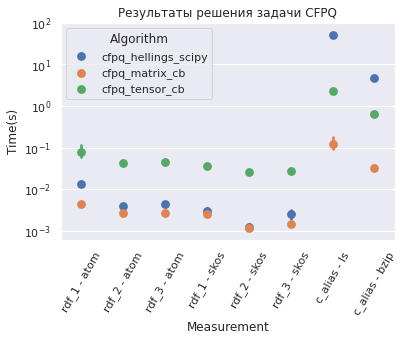

In [65]:
def plot_cfpq_results():
    res = create_df("cfpq", SMALL_GRAPHS, CFPQ_ALGORITHMS)
    res["Measurement"] = res["Query"] + " - " + res["Graph"]
    res.drop(columns=["Graph", "Query"])
    ax = plt.subplot()
    ax.set(yscale="log")
    g = sns.pointplot(
        data=res,
        x="Measurement",
        y="Time(s)",
        hue="Algorithm",
        join=False,
        ax=ax,
    )
    g.set_title("Результаты решения задачи CFPQ")
    g.set_xticklabels(g.get_xticklabels(), rotation=60)


plot_cfpq_results()

### Результаты сравнения алгоритмов специализированного решения RPQ задачи и RPQ как CFPQ

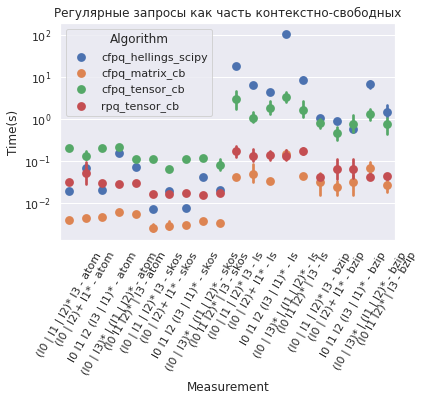

In [62]:
def plot_cfpq_results():
    res = pd.concat([create_df("cfg", SMALL_GRAPHS, CFPQ_ALGORITHMS), 
                     create_df("rpq", SMALL_GRAPHS, RPQ_ALGORITHMS)], ignore_index=True)
    res["Measurement"] = res["Query"] + " - " + res["Graph"]
    res.drop(columns=["Graph", "Query"])
    ax = plt.subplot()
    ax.set(yscale="log")
    g = sns.pointplot(
        data=res,
        x="Measurement",
        y="Time(s)",
        hue="Algorithm",
        join=False,
        ax=ax,
    )
    g.set_title("Регулярные запросы как часть контекстно-свободных")
    g.set_xticklabels(g.get_xticklabels(), rotation=60)


plot_cfpq_results()

### Заключение
TODO